HCI Based Vision Model
Author: Md Shafiur Rahman Khan

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import requests
import os
import zipfile
import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
from tqdm.notebook import tqdm

In [2]:
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = '#f8f9fa'
plt.rcParams['axes.grid'] = True

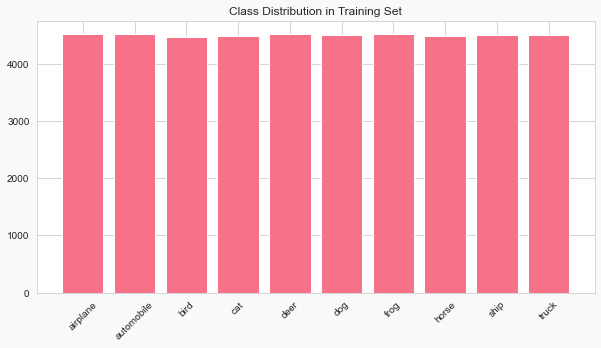

In [3]:
def load_cifar10_data():
    """Load CIFAR-10 data with interactive progress feedback"""
    
    # Create HCI widgets
    progress = widgets.FloatProgress(min=0, max=100, description='Loading:')
    status = widgets.Label(value="Preparing to download CIFAR-10...")
    display(widgets.VBox([status, progress]))
    
    try:
        # Update status
        status.value = "Downloading dataset..."
        progress.value = 10
        
        # Load CIFAR-10 from Keras datasets
        (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
        
        # Normalize pixel values
        X_train = X_train.astype('float32') / 255
        X_test = X_test.astype('float32') / 255
        
        # Convert class vectors to binary class matrices
        y_train = keras.utils.to_categorical(y_train, 10)
        y_test = keras.utils.to_categorical(y_test, 10)
        
        status.value = "Preprocessing images..."
        progress.value = 70
        
        # Create validation set
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.1, random_state=42)
        
        status.value = f"Ready! Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}"
        progress.value = 100
        
        # Show class distribution
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                      'dog', 'frog', 'horse', 'ship', 'truck']
        
        fig, ax = plt.subplots(figsize=(10, 5))
        class_counts = np.sum(y_train, axis=0)
        ax.bar(class_names, class_counts)
        ax.set_title("Class Distribution in Training Set")
        ax.set_xticklabels(class_names, rotation=45)
        plt.show()
        
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), class_names
    
    except Exception as e:
        status.value = f"Error: {str(e)}"
        raise

# Load the data
(X_train, y_train), (X_val, y_val), (X_test, y_test), class_names = load_cifar10_data()

In [6]:
def build_interactive_model(input_shape=(32, 32, 3), num_classes=10):
    """Interactive model builder with HCI principles"""
    
    # HCI Widgets for model configuration
    arch_type = widgets.Dropdown(
        options=['SimpleCNN', 'ResNet', 'EfficientNet'],
        description='Architecture:',
        style={'description_width': 'initial'}
    )
    
    num_layers = widgets.IntSlider(
        value=2,
        min=1,
        max=4,
        description='Conv Layers:',
        style={'description_width': 'initial'}
    )
    
    filters_base = widgets.IntSlider(
        value=32,
        min=16,
        max=128,
        step=16,
        description='Base Filters:',
        style={'description_width': 'initial'}
    )
    
    dense_units = widgets.IntSlider(
        value=128,
        min=64,
        max=512,
        step=64,
        description='Dense Units:',
        style={'description_width': 'initial'}
    )
    
    dropout_rate = widgets.FloatSlider(
        value=0.3,
        min=0.0,
        max=0.5,
        step=0.1,
        description='Dropout Rate:',
        style={'description_width': 'initial'}
    )
    
    build_button = widgets.Button(
        description="Build Model",
        button_style='success',
        tooltip="Click to construct the model"
    )
    
    output = widgets.Output()
    
    def on_build_click(b):
        with output:
            clear_output(wait=True)
            print(f"Building {arch_type.value} model with:")
            print(f"- {num_layers.value} convolutional layers")
            print(f"- {filters_base.value} base filters")
            print(f"- {dense_units.value} dense units")
            print(f"- {dropout_rate.value} dropout rate")
            
            model = keras.Sequential()
            model.add(layers.Input(shape=input_shape))
            
            # Common initial layers
            model.add(layers.experimental.preprocessing.Rescaling(1./255))
            
            # Architecture selection
            if arch_type.value == 'SimpleCNN':
                for i in range(num_layers.value):
                    model.add(layers.Conv2D(
                        filters_base.value * (2**i),
                        kernel_size=3,
                        activation='relu',
                        padding='same'))
                    model.add(layers.BatchNormalization())
                    model.add(layers.MaxPooling2D(pool_size=2))
                    model.add(layers.Dropout(dropout_rate.value))
            
            elif arch_type.value == 'ResNet':
                # Simplified ResNet blocks
                def resnet_block(x, filters, kernel_size=3):
                    y = layers.Conv2D(filters, kernel_size, padding='same')(x)
                    y = layers.BatchNormalization()(y)
                    y = layers.Activation('relu')(y)
                    y = layers.Conv2D(filters, kernel_size, padding='same')(y)
                    y = layers.BatchNormalization()(y)
                    return layers.add([x, y])
                
                # Initial conv
                x = layers.Conv2D(filters_base.value, 3, padding='same')(model.output)
                x = layers.BatchNormalization()(x)
                x = layers.Activation('relu')(x)
                
                # ResNet blocks
                for i in range(num_layers.value):
                    x = resnet_block(x, filters_base.value * (2**i))
                    x = layers.MaxPooling2D(2)(x)
                    x = layers.Dropout(dropout_rate.value)(x)
                
                model = keras.Model(model.input, x)
            
            # Common classifier head
            model.add(layers.Flatten())
            model.add(layers.Dense(dense_units.value, activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(dropout_rate.value + 0.1))
            model.add(layers.Dense(num_classes, activation='softmax'))
            
            # Compile with multiple metrics
            model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=[
                    'accuracy',
                    keras.metrics.Precision(name='precision'),
                    keras.metrics.Recall(name='recall'),
                    keras.metrics.AUC(name='auc')
                ]
            )
            
            print("\nModel summary:")
            model.summary()
            
            global current_model
            current_model = model
    
    build_button.on_click(on_build_click)
    
    display(widgets.VBox([
        widgets.HBox([arch_type, num_layers]),
        widgets.HBox([filters_base, dense_units]),
        widgets.HBox([dropout_rate, build_button]),
        output
    ]))

# Run the interactive builder
build_interactive_model()

In [5]:
def train_model_interactive(X_train, y_train, X_val, y_val):
    """Interactive training with live feedback"""
    
    # HCI Widgets
    epochs = widgets.IntSlider(
        value=20,
        min=5,
        max=50,
        step=5,
        description='Epochs:'
    )
    
    batch_size = widgets.Dropdown(
        options=[32, 64, 128, 256],
        value=64,
        description='Batch Size:'
    )
    
    # Training control buttons
    train_button = widgets.Button(
        description="Start Training",
        button_style='success',
        disabled=False
    )
    
    stop_button = widgets.Button(
        description="Stop Training",
        button_style='danger',
        disabled=True
    )
    
    # Visualization areas
    live_plot = widgets.Output()
    metrics_display = widgets.Output()
    
    # Training control
    stop_training = False
    
    def on_train_click(b):
        nonlocal stop_training
        stop_training = False
        train_button.disabled = True
        stop_button.disabled = False
        
        with live_plot:
            clear_output(wait=True)
            fig, ax = plt.subplots(1, 2, figsize=(14, 5))
            plt.close(fig)  # Prevents duplicate display
            display(fig)
        
        # Custom callback for live updates
        class LiveUpdateCallback(keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                if stop_training:
                    self.model.stop_training = True
                    return
                
                with live_plot:
                    clear_output(wait=True)
                    
                    # Update metrics display
                    with metrics_display:
                        clear_output(wait=True)
                        print(f"Epoch {epoch+1}/{epochs.value}")
                        print(f"Loss: {logs['loss']:.4f} | Accuracy: {logs['accuracy']:.4f}")
                        print(f"Val Loss: {logs['val_loss']:.4f} | Val Accuracy: {logs['val_accuracy']:.4f}")
                    
                    # Update plots
                    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
                    
                    # Accuracy plot
                    axes[0].plot(self.model.history.history['accuracy'][:epoch+1], label='Train')
                    axes[0].plot(self.model.history.history['val_accuracy'][:epoch+1], label='Validation')
                    axes[0].set_title('Model Accuracy')
                    axes[0].set_xlabel('Epoch')
                    axes[0].legend()
                    
                    # Loss plot
                    axes[1].plot(self.model.history.history['loss'][:epoch+1], label='Train')
                    axes[1].plot(self.model.history.history['val_loss'][:epoch+1], label='Validation')
                    axes[1].set_title('Model Loss')
                    axes[1].set_xlabel('Epoch')
                    axes[1].legend()
                    
                    plt.tight_layout()
                    clear_output(wait=True)
                    display(fig)
        
        # Start training
        history = current_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs.value,
            batch_size=batch_size.value,
            verbose=0,
            callbacks=[
                LiveUpdateCallback(),
                keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    patience=3,
                    restore_best_weights=True
                )
            ]
        )
        
        # Final evaluation if not stopped
        if not stop_training:
            evaluate_model(current_model, X_val, y_val, class_names)
        
        train_button.disabled = False
        stop_button.disabled = True
    
    def on_stop_click(b):
        nonlocal stop_training
        stop_training = True
        with metrics_display:
            print("\nTraining stopped by user")
        train_button.disabled = False
        stop_button.disabled = True
    
    train_button.on_click(on_train_click)
    stop_button.on_click(on_stop_click)
    
    # Display the interface
    display(widgets.VBox([
        widgets.HBox([epochs, batch_size]),
        widgets.HBox([train_button, stop_button]),
        live_plot,
        metrics_display
    ]))
